COVID-19 Immunity Screening Project Step 3. The document uses .csv files from the final data and classifies the unknown samples into the categories by using the known samples. 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import pylab as pl
from sklearn.tree import export_graphviz


In [9]:
%matplotlib inline

# Graphing Function

In [10]:
'''
Plots scatter plot for given dataframe

parameters df : teh dataframe to plot
return : graph
'''
def plot_graph(df):
    y = [df['M_WT'].tolist(),
         df['M_Om'].tolist(),
         df['RBD_WT'].tolist(),
         df['RBD_Om'].tolist(),
         df['N_WT'].tolist(),
         df['S_WT'].tolist()]

    x = [1,2,3,4,5,6]
    fig, ax = plt.subplots()
    for xe, ye in zip(x, y):
        plt.scatter([xe] * len(ye), ye, s = 20, label = "Mean %.2f"%(np.mean(ye)))
        ax.hlines(y=np.mean(ye), xmin=xe-0.25, xmax=xe+0.25, linewidth=2, color='k')

    plt.xticks(x, ["M_WT", "M_Om", "RBD_WT", "RBD_Om", "N_WT", "S_WT"])
    plt.ylim(-40,60)
    plt.legend()
    return plt.show()

# Load Samples

In [11]:
knownSamples_df = pd.read_csv("AllKnownSamples.csv")
knownSamplesSansNaive = knownSamples_df[knownSamples_df.Type != "Naive"]
patient_df = pd.read_csv("PatientDataAug22.csv")
grouped = knownSamples_df.groupby(knownSamples_df.Type)
naive_df = grouped.get_group("Naive")
convalescent_df = grouped.get_group("Convalescent")
convalescent_Vaccinated_df = grouped.get_group("Convalescent Vaccinated")
naive_Vaccinated_df = grouped.get_group("Naive Vaccinated")

# Create an Instance of Random Forest Clasifier Object

In [12]:
#Prepare variables
X = knownSamples_df[["M_WT", "M_Om", "RBD_WT", "RBD_Om", "N_WT", "S_WT"]]
y = knownSamples_df["Type"]

#Just to make sure we got the same result every time
random_state = 203


# number of trees 1000 
rfc_clf = RandomForestClassifier(n_estimators=1000, random_state = random_state)
#fit to known data
rfc_clf.fit(X, y)

RandomForestClassifier(n_estimators=1000, random_state=203)

# Get Prediction

In [13]:
y_pred_proba = rfc_clf.predict_proba(patient_df[["M_WT", "M_Om", "RBD_WT", "RBD_Om", "N_WT", "S_WT"]])

print(rfc_clf.classes_)
pred = ["%s"%(rfc_clf.classes_[np.argmax(y_pred_proba[i])]) for i in range(len(y_pred_proba))]
patient_df["Prediction"] = pred

['Convalescent' 'Convalescent Vaccinated' 'Naive' 'Naive Vaccinated']


# Show Prediction

In [14]:
#pd.set_option('display.max_rows', 500)
#https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
#pd.set_option('display.max_rows', 500)

patient_df

,Patients,M_WT,M_Om,RBD_WT,RBD_Om,N_WT,S_WT,Type,Prediction
0,P1,8.482172,11.806317,21.232168,22.174464,14.112501,25.638562,Unknown Patients,Convalescent Vaccinated
1,P2,7.609592,-0.372014,30.656973,24.690211,25.620180,31.132632,Unknown Patients,Convalescent Vaccinated
2,P3,6.420643,-3.173077,26.384088,23.240334,32.647651,33.215499,Unknown Patients,Convalescent Vaccinated
3,P4,9.695417,-8.490191,33.743325,25.674987,7.401033,34.541291,Unknown Patients,Convalescent Vaccinated
4,P5,-1.560375,-9.227453,22.031263,10.016084,5.635871,27.028883,Unknown Patients,Convalescent Vaccinated
...,...,...,...,...,...,...,...,...,...
95,P96,-9.594155,-20.475578,21.708217,16.602360,-19.524615,24.468714,Unknown Patients,Naive Vaccinated
96,P97,-13.841574,-14.634037,27.154133,16.524664,2.768431,27.869931,Unknown Patients,Naive Vaccinated
97,P98,1.669610,-9.828577,42.073083,35.634121,13.999468,38.522685,Unknown Patients,Convalescent Vaccinated
98,P99,-9.040446,-15.233506,20.507824,15.365314,-19.790427,15.573801,Unknown Patients,Naive Vaccinated


# Show Feature Importance

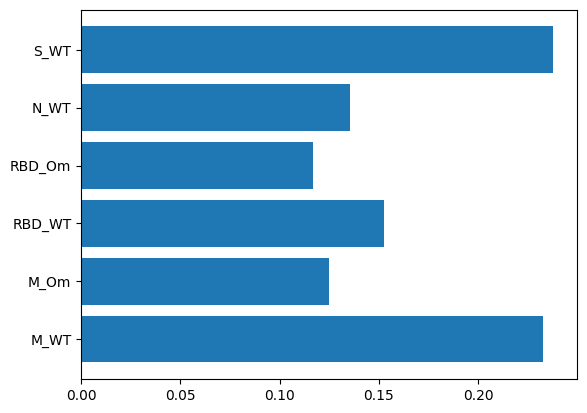

In [15]:
fig, ax = plt.subplots()
graph = ax.barh(["M_WT", "M_Om", "RBD_WT", "RBD_Om", "N_WT", "S_WT"],rfc_clf.feature_importances_)
#ax.bar_label(graph, padding = 8)
ax.spines["right"].set_visible(True)
ax.spines["top"].set_visible(True)

In [16]:
patients_grouped = patient_df.groupby(patient_df.Prediction)
predicted_naive_df = patients_grouped.get_group("Naive")
predicted_convalescent_df = patients_grouped.get_group("Convalescent")
predicted_convalescent_Vaccinated_df = patients_grouped.get_group("Convalescent Vaccinated")
predicted_naive_Vaccinated_df = patients_grouped.get_group("Naive Vaccinated")

# Plot

Naive Vaccinated N = 41


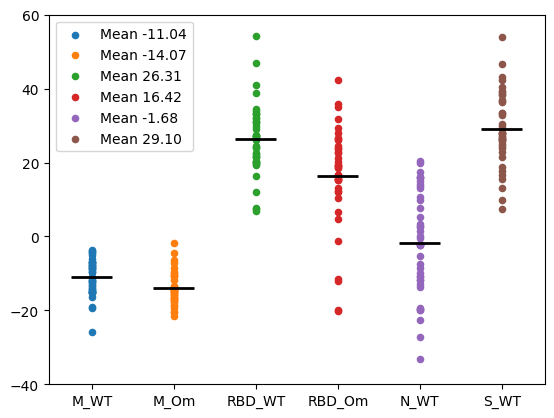

Known Samples N=18


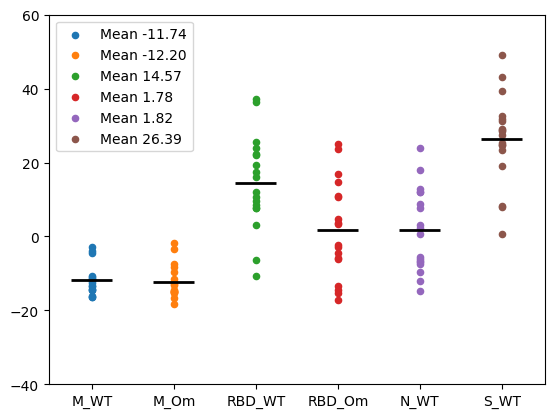

In [19]:
print("Naive Vaccinated N = %s"%len(predicted_naive_Vaccinated_df))

plot_graph(predicted_naive_Vaccinated_df)

print("Known Samples N=18")
plot_graph(naive_Vaccinated_df)

Convalescent N = 9


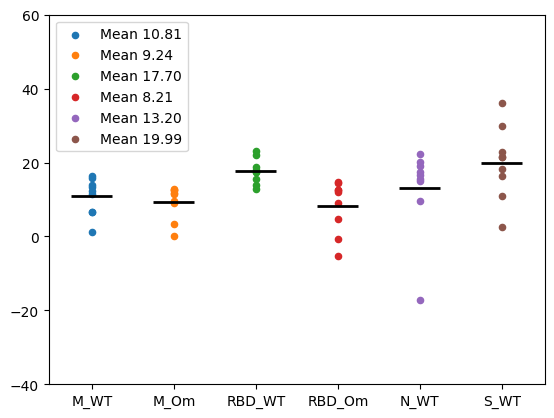

Known Samples N=18


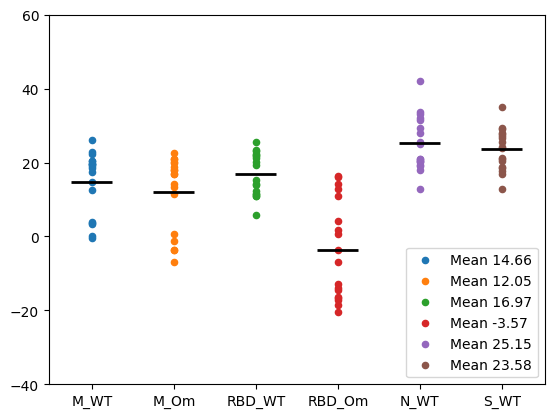

In [20]:
print("Convalescent N = %s"%len(predicted_convalescent_df))

plot_graph(predicted_convalescent_df)
print("Known Samples N=18")

plot_graph(convalescent_df)


Convalescent Vaccinated N = 46


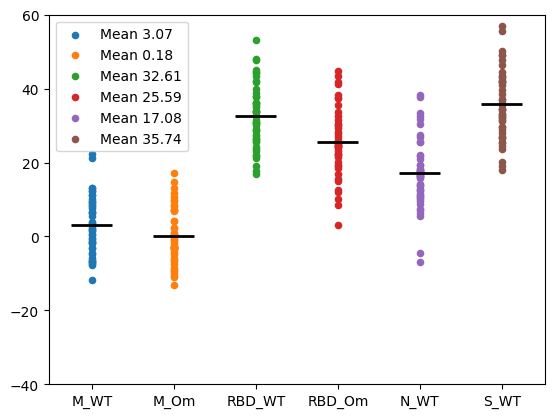

Known Samples N=18


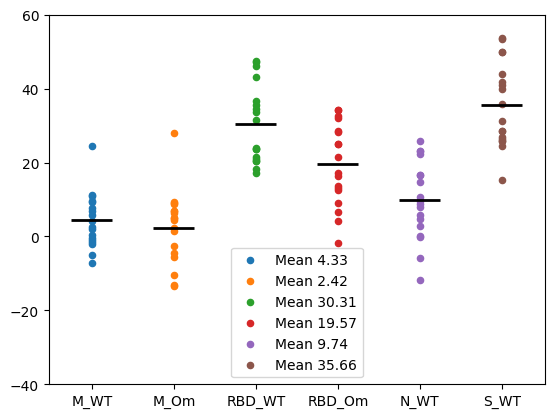

In [21]:
print("Convalescent Vaccinated N = %s"%len(predicted_convalescent_Vaccinated_df))
plot_graph(predicted_convalescent_Vaccinated_df)
print("Known Samples N=18")
plot_graph(convalescent_Vaccinated_df)



Naive N = 4


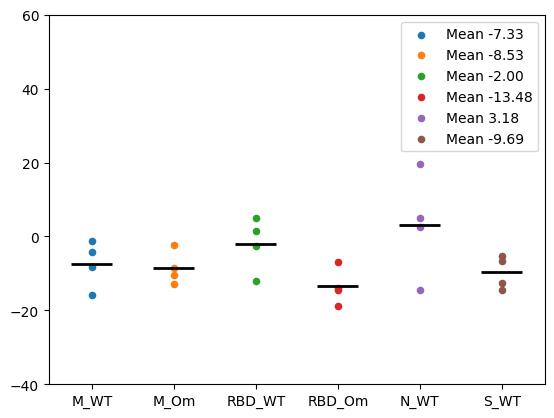

Known Samples N=18


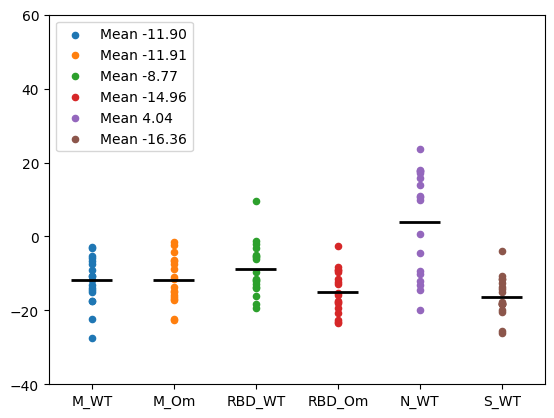

In [22]:
print("Naive N = %s"%len(predicted_naive_df))
plot_graph(predicted_naive_df)
print("Known Samples N=18")
plot_graph(naive_df)


# Get patients who was predicted to have had COVID

In [23]:
convalescentTotal = patient_df[(patient_df.Prediction == "Convalescent") | (patient_df.Prediction == "Convalescent Vaccinated")]
convalescentKnownTotal = knownSamples_df[(knownSamples_df.Type == "Convalescent") | (knownSamples_df.Type == "Convalescent Vaccinated")]

In [24]:
convalescentTotal["RBD_Difference"] = convalescentTotal["RBD_WT"] - convalescentTotal["RBD_Om"]
convalescentKnownTotal["RBD_Difference"] = convalescentKnownTotal["RBD_WT"] - convalescentKnownTotal["RBD_Om"]

C:\Users\wadi2\AppData\Local\Temp\ipykernel_27644\416452941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convalescentTotal["RBD_Difference"] = convalescentTotal["RBD_WT"] - convalescentTotal["RBD_Om"]
C:\Users\wadi2\AppData\Local\Temp\ipykernel_27644\416452941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convalescentKnownTotal["RBD_Difference"] = convalescentKnownTotal["RBD_WT"] - convalescentKnownTotal["RBD_Om"]


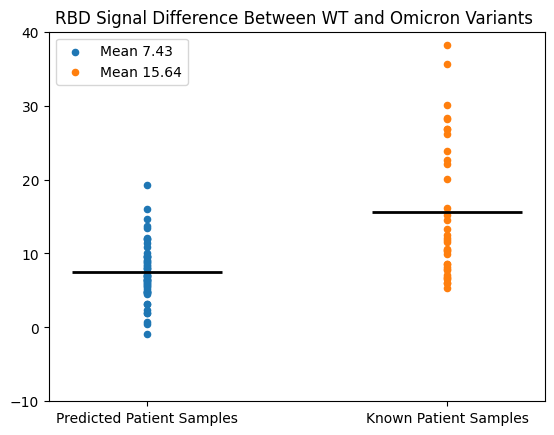

In [25]:
x = [1,2]
y = [ convalescentTotal["RBD_Difference"].tolist(), convalescentKnownTotal["RBD_Difference"].tolist()]
fig, ax = plt.subplots()
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye, s = 20, label = "Mean %.2f"%(np.mean(ye)))
    ax.hlines(y=np.mean(ye), xmin=xe-0.25, xmax=xe+0.25, linewidth=2, color='k')


plt.xticks(x, [ "Predicted Patient Samples", "Known Patient Samples"])
plt.ylim(-10,40)
plt.title('RBD Signal Difference Between WT and Omicron Variants ')
plt.legend()